# 0. Import Libraries

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load Images and Match Templates for 3D reconstruction

In [3]:
def img_load(i):
    img1 = cv.imread(img_dir + str(i) + '.tif')
    img2 = cv.imread(img_dir + str(i+1) + '.tif')
    
    black1 = np.zeros(img1.shape)
    black2 = np.zeros(img2.shape)
    
    d1 = pd.read_csv(con_dir + str(i) + '.csv')
    d2 = pd.read_csv(con_dir + str(i+1) + '.csv')
    
    ncm_target = d1['ncm'].tolist()
    ncm_target = [eval(j) for j in ncm_target]
    
    ncm_next_tar = d2['ncm'].tolist()
    ncm_next_tar = [eval(j) for j in ncm_next_tar]
    
    return img1, img2, ncm_target, ncm_next_tar, black1, black2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


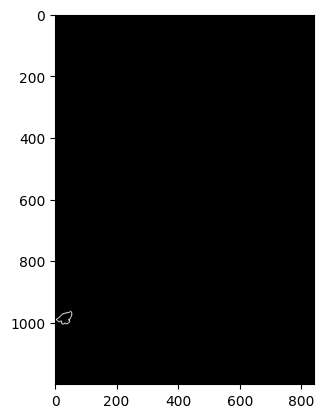

0.4144725203514099


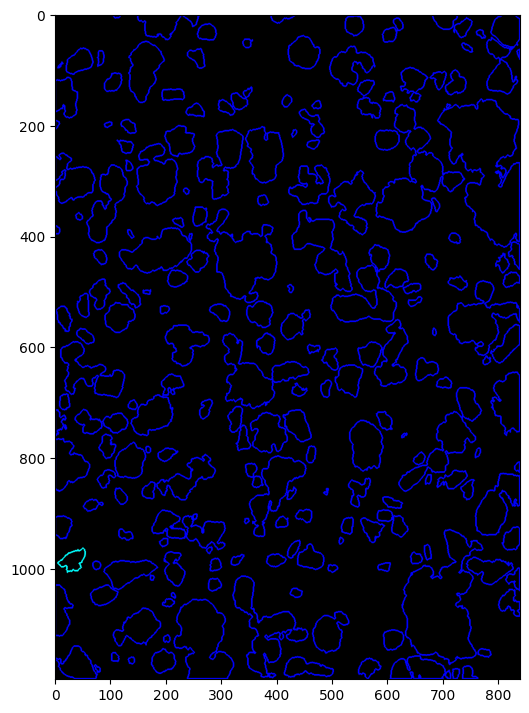

0
0.4366958439350128


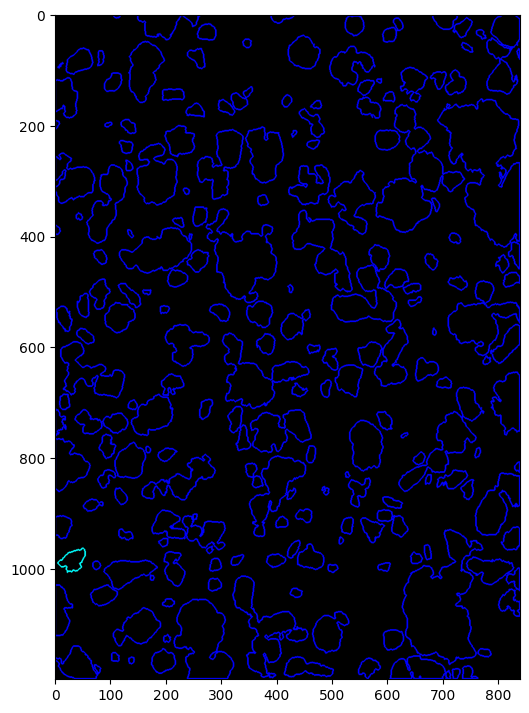

1
0.4023361802101135


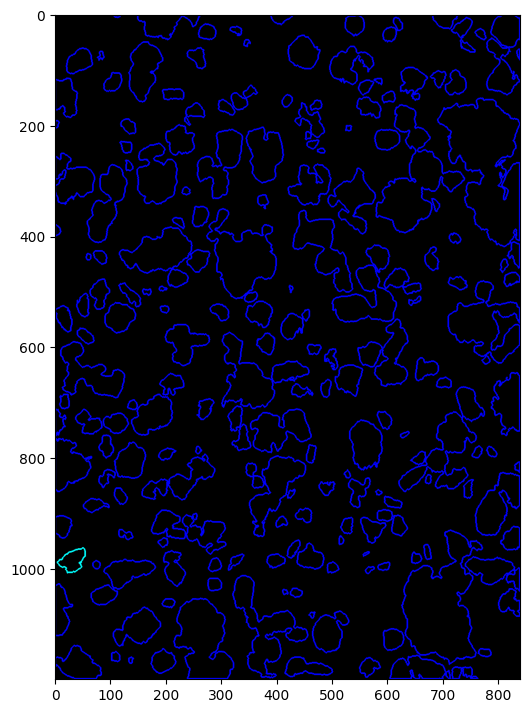

2
0.44500213861465454


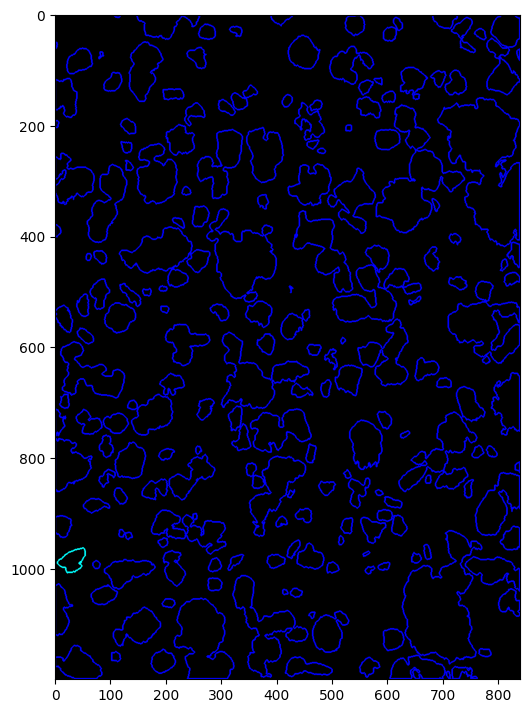

3


In [332]:
img_dir = '/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240425/0.data/3d_contour_tif/'
con_dir = '/home/sbml/Desktop/0.solid_electrolyte/FIB_SEM_240430/0.bare/3d_contour_test/'

number = 0 
score, number_frame, number_ncm, center_cordi = [], [], [], []

for i in range(0, 607):
    img1, img2, ncm_target, ncm_next_tar, black1, black2 = img_load(i)
    cnt = np.array(ncm_target[number]) 
    M = cv.moments(cnt)
    window_start = [min(cnt[:,:,0])[0], min(cnt[:,:,1])[0]]
    window_end = [max(cnt[:,:,0])[0], max(cnt[:,:,1])[0]]
    cv.drawContours(black1, cnt, -1, (255, 255, 255), 2, cv.LINE_4) 
    ncm_l = []
    score_l = []
    if i == 0:
        M = cv.moments(cnt)
        plt.imshow(black1)
        plt.show()
        number_frame.append(i)
        number_ncm.append(number)
        center_cordi.append([int(M['m10']/M['m00']), int(M['m01']/M['m00'])])

    img_test = black1[window_start[1]: window_end[1], window_start[0]: window_end[0]]
    template = img_test.astype(np.uint8)
    th, tw = template.shape[:2]
        
    for k in range(len(ncm_next_tar)):
        cnt1 = np.array(ncm_next_tar[k])
        window_start = [min(cnt1[:,:,0])[0], min(cnt1[:,:,1])[0]]
        window_end = [max(cnt1[:,:,0])[0], max(cnt1[:,:,1])[0]]
        cv.drawContours(black2, cnt1, -1, (0, 0, 255), 2, cv.LINE_4) 
        
        img_ncm = black2[window_start[1]: window_end[1], window_start[0]: window_end[0]]
        img_ncm = cv.resize(img_ncm, dsize = (template.shape[1]+1, template.shape[0]+1), interpolation = cv.INTER_AREA)
        img_ncm  = img_ncm.astype(np.uint8)  
        ncm_l.append(img_ncm)
        
    for count in ncm_l:
        method = cv.TM_CCOEFF_NORMED
        res = cv.matchTemplate(count, template, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        score_l.append(max_val)
        
    maximum = max(score_l)
    number = score_l.index(maximum)
    cnt2 = np.array(ncm_next_tar[number])
    
    if maximum > 0.40:
        M = cv.moments(cnt2)
        center_cordi.append([int(M['m10']/M['m00']), int(M['m01']/M['m00'])])
        cv.drawContours(img2, cnt2, -1, (0, 255, 255), 2, cv.LINE_4) 
        number_frame.append(i+1)
        number_ncm.append(number)
        print(maximum)
    
    else :
        break
        
    plt.figure(figsize = (6, 12))
    plt.imshow(img2)
    plt.show()
    print(i)
    

In [ ]:
df = pd.DataFrame({})
df['#frame'] = number_frame
df['#ncm'] = number_ncm
df['center'] = center_cordi
#df.to_csv(f'/home/sbml/Desktop/0.solid_electrolyte/Remaining_240523/0.bare/cathode_particle/frame{f}_num40.csv')
df